In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import pydicom


def show_study_info(study_id, df, df_findings, df_sections, df_sentences):
    print(f"\n===== Información para original studyID: {study_id} =====\n")

    #%% map ids 
    ids = pd.read_parquet("/mnt/nas_anakena/datasets/uc-cxr/processed_data/metadata/private_phi_index.parquet")
    study_id_anon = ids[ids['PHI'] == study_id]['ANON'].values[0]

    df = pd.read_parquet("/mnt/nas_anakena/datasets/uc-cxr/processed_data/metadata/anon.parquet")
    print(f"\n===== Información para anonymized studyID: {study_id_anon} =====\n")

    # --- Display DICOM images for the study ---
    study_df = df[(df['StudyInstanceUID'] == study_id_anon) & (df['SeriesDescription'] != 'Report')]
    study_dicom_paths = study_df['file_path'].tolist()

    if study_dicom_paths:
        num_images = len(study_dicom_paths)
        fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
        
        # Handle the case of a single image
        if num_images == 1:
            axes = [axes]

        for i, path in enumerate(study_dicom_paths):
            if study_df.iloc[i]['SeriesDescription'].lower() != 'report':
                try:
                    ds_all = pydicom.dcmread(path)
                    img_all = ds_all.pixel_array
                    axes[i].imshow(img_all, cmap="gray")
                    axes[i].set_title(f"Image {i+1}")
                    axes[i].axis("off")
                except Exception as e:
                    print(f"Error loading DICOM file {path}: {e}")
                    axes[i].set_title(f"Error loading Image {i+1}")
                    axes[i].axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print("No images found for this StudyInstanceUID.")
    
    
    
    print("-" * 50) # Separator
    # --- Archivo 1: 100k_llm_finding_labels.csv ---
    study_finding = df_findings[df_findings["studyID"] == study_id]
    if not study_finding.empty:
        row = study_finding.iloc[0]
        print("📌 Archivo: 100k_llm_findings_labels.csv")
        print(f" - study_date: {row.get('study_date', 'N/A')}")
        print(f" - age: {row.get('age', 'N/A')}")
        print(f" - report_text:\n{row.get('report_text', 'N/A')}\n")
        print(f" - regex_labels: {row.get('regex_labels', 'N/A')}")
        print(f" - llm_labels: {row.get('llm_labels', 'N/A')}")
        
        cols = df_findings.columns[8:-1]
        label_status = row[cols]
        print("\n - Estado de labels (ciertas/maybe/false...):")
        print(label_status[label_status.notna()].to_dict())
        print("\n")
    else:
        print("❌ No se encontró en 100k_llm_findings_labels.csv\n")
    

    print("-" * 50) # Separator
    # --- Archivo 2: sections_of_report.csv ---
    study_sections = df_sections[df_sections["studyID"] == study_id]
    if not study_sections.empty:
        row = study_sections.iloc[0]
        print("📌 Archivo: sections_of_report.csv")
        print(f" - projections: {row.get('projections', 'N/A')}")
        print(f" - history: {row.get('history', 'N/A')}")
        print(f" - finding_sentences_es: {row.get('finding_sentences_es', 'N/A')}")
        print(f" - finding_sentences_en: {row.get('finding_sentences_en', 'N/A')}\n")
    else:
        print("❌ No se encontró en sections_of_report.csv\n")
    
    
    print("-" * 50) # Separator
    # --- Archivo 3: labels_per_sentence_5k.csv ---
    study_sentences = df_sentences[df_sentences["studyID"] == study_id]
    if not study_sentences.empty:
        print("📌 Archivo: labels_per_sentence_5k.csv")
        for _, row in study_sentences.iterrows():
            print(f" - sentence_index: {row['sentence_index']}")
            print(f"   sentence_text: {row['sentence_text']}")
            print(f"   positive_or_not: {row['positive_or_not']}")
            print(f"   findings_affirmed: {row['findings_affirmed']}\n")
    else:
        print("❌ No se encontró en labels_per_sentence_5k.csv\n")



/tmp/ipykernel_81928/3230396182.py:6: DtypeWarning: Columns (10,17,24,32,44,46,47,60,63,85,93,115,116,122,135,136,140,147,164,166) have mixed types. Specify dtype option on import or set low_memory=False.
  df_findings = pd.read_csv(f"{base_path}/100k_llm_findings_labels.csv")



===== Información para original studyID: 1.3.51.0.1.1.146.155.249.152.4670873.4670864 =====


===== Información para anonymized studyID: 1.3.51.0.1.1.146.155.249.152.971261.3013 =====



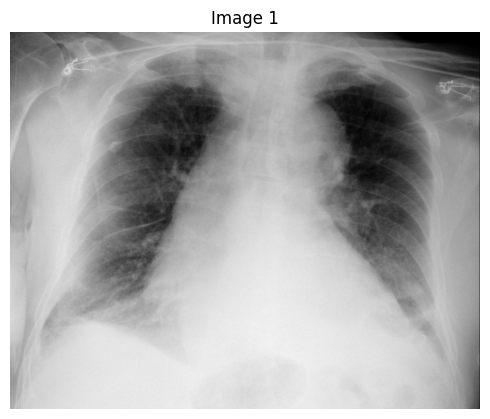

--------------------------------------------------
📌 Archivo: 100k_llm_findings_labels.csv
 - study_date: 02/01/2018
 - age: 89
 - report_text:
RADIOGRAFÍA DE TÓRAX ANTEROPOSTERIOR - PORTÁTIL 
Antecedentes clínicos: Dolor precordial. Angioplastia coronaria año 2014. Cardiopatía coronaria. 
Hallazgos: 
Diafragma bien posicionado. 
Tenue velo de disposición posterior que opacifica los tercios inferiores de ambos hemitórax, 
compatible con leve derrame pleural. 
No hay signos categóricos de neumotórax. 
Opacidades parenquimatosas de relleno alveolar en la base de ambos hemitorax, probablemente 
determinado por atelectasias. 
Moderado aumento de tamaño de la silueta cardíaca 
No hay signos categóricos de edema intersticial. 
Ensanchamiento de mediastino superior, más probablemente determinado por acentuada 
elongación de la aorta torácica. 
Hilios  y dibujo vascular pulmonar sin alteraciones. 


 - regex_labels: ['Abnormal bronchovascular markings', 'Alveolar pattern', 'Aortic atheromatosi

In [4]:
# Load metadata parquet
df = pd.read_parquet("/mnt/nas_anakena/datasets/uc-cxr/processed_data/metadata/anon.parquet")

# Cargar los tres archivos CSV
base_path = "/mnt/nas_anakena/datasets/uc-cxr/processed_data/reports_and_labels_llm"
df_findings = pd.read_csv(f"{base_path}/100k_llm_findings_labels.csv")
df_sections = pd.read_csv(f"{base_path}/sections_of_report.csv")
df_sentences = pd.read_csv(f"{base_path}/labels_per_sentence_5k.csv")



# original studies ids
#study_id = "1.3.51.0.1.1.146.155.249.152.4685561.4685552"
study_id = "1.3.51.0.1.1.146.155.249.152.4670873.4670864"
# study_id = "1.3.51.0.1.1.146.155.249.152.8105806.8105890"
# study_id = "1.3.51.0.1.1.146.155.249.152.6424054.6424046"
# study_id = "1.3.51.0.1.1.146.155.249.152.4669407.4669398"


# ==== Ejemplo de uso ====
show_study_info(study_id=study_id, df=df, df_findings=df_findings, df_sections=df_sections, df_sentences=df_sentences)
